In [74]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time

In [89]:
sleeps = pd.read_csv('sleeps.csv')
sleeps = sleeps[sleeps.user_id!=2509]
sleeps = sleeps[sleeps.user_id!=2461]

In [90]:
def epoch_end_convert(df):
    '''
    takes dataframe and converts date column to epoch milliseconds
    inputs:
        df = dataframe name
    '''
    try:
        return (int(time.mktime(time.strptime(df['end'], '%Y-%m-%d %H:%M:%S'))) - 14400)*1000
    except:
        #handles activities that have fractions of a second included
        return (int(time.mktime(time.strptime(df['end'][:19], '%Y-%m-%d %H:%M:%S'))) - 14400)*1000

In [91]:
sleeps['end_epoch'] = sleeps.apply(epoch_end_convert, axis=1)

In [92]:
#drop if HRV = NaN
sleeps_only = sleeps[np.isnan(sleeps.hrv_rmssd)==False]

In [94]:
sleeps.head()

,user_id,start,end,score,time_in_bed,latency,disturbances,wake_duration,light_sleep_duration,slow_wave_sleep_duration,rem_sleep_duration,cycles_count,debt_post,is_nap,recovery_score,resting_heart_rate,hrv_rmssd,end_epoch
0,828,2015-09-15 02:42:00,2015-09-15 12:09:00,82,34020000,2100132,27,6870000,22230000,3600000,1320000,2,4266209.55,f,63,49,0.064647,1442318940000
1,828,2015-09-16 02:03:00,2015-09-16 12:06:00,87,36180000,2790134,25,6630000,22860000,3210000,3480000,3,2436815.25,f,74,45,0.075670,1442405160000
2,828,2015-09-17 00:36:00,2015-09-17 12:15:00,97,41940000,7800470,24,10410000,25680000,3240000,2580000,4,513169.69,f,68,44,0.036925,1442492100000
3,828,2015-09-18 02:38:18.552,2015-09-18 12:24:08.679,94,35150127,1410042,32,3960000,24810000,2160000,4230000,7,1425316.75,f,90,53,0.098787,1442579048000
4,828,2015-09-19 01:44:23.818,2015-09-19 11:30:18.277,0,0,0,NaN,0,0,0,0,NaN,NaN,f,NaN,NaN,NaN,1442662218000


#Adding In Race Periods

In [80]:
date_markers = pd.read_csv('epoch_dates.csv')

In [81]:
date_markers.head()

,ET_Date,date_start_epoch,race_period,bike_period,race_period_start,race_period_end,bike_period_start,bike_period_end
0,9/15/2015 0:00,1442289600000,1,1,1,0,1,0
1,9/16/2015 0:00,1442376000000,1,1,0,0,0,0
2,9/17/2015 0:00,1442462400000,1,1,0,0,0,0
3,9/18/2015 0:00,1442548800000,1,1,0,0,0,0
4,9/19/2015 0:00,1442635200000,1,1,0,0,0,0


In [82]:
date_markers = date_markers[date_markers['race_period_start'] > 0].reset_index()
#dictionary of race period to start epoch
race_start_dict = {}
for i in range(0, len(date_markers)):
    race_start_dict[date_markers.values[i][3]] = date_markers.values[i][2]

#date_markers = date_markers[date_markers['bike_period_start'] > 0].reset_index()
#bike_start_dict = {}
#for i in range(0, len(date_markers)):
#    bike_start_dict[date_markers.values[i][4]] = date_markers.values[i][2]


In [83]:
race_start_dict

{1L: 1442289600000L,
 2L: 1443240000000L,
 3L: 1445054400000L,
 4L: 1446264000000L,
 5L: 1447473600000L}

In [84]:
def add_race(df):
    if (df.end_epoch >= race_start_dict[1]) and (df.end_epoch < race_start_dict[2]):
        return 1
    elif (df.end_epoch >= race_start_dict[2]) and (df.end_epoch < race_start_dict[3]):
        return 2
    elif (df.end_epoch >= race_start_dict[3]) and (df.end_epoch < race_start_dict[4]):
        return 3
    elif (df.end_epoch >= race_start_dict[4]) and (df.end_epoch < race_start_dict[5]):
        return 4
    elif (df.end_epoch >= race_start_dict[5]) and (df.end_epoch < 1448164800000):
        return 5
    else:
        return 0


In [85]:
def add_bike(df):
    if (df.end_epoch >= bike_start_dict[1]) and (df.end_epoch < bike_start_dict[2]):
        return 1
    elif (df.end_epoch >= bike_start_dict[2]) and (df.end_epoch < bike_start_dict[3]):
        return 2
    elif (df.end_epoch >= race_start_dict[3]) and (df.end_epoch < bike_start_dict[4]):
        return 3
    elif (df.end_epoch >= bike_start_dict[4]) and (df.end_epoch < bike_start_dict[5]):
        return 4
    elif (df.end_epoch >= bike_start_dict[5]) and (df.end_epoch < bike_start_dict[6]):
        return 5
    elif (df.end_epoch >= bike_start_dict[6]) and (df.end_epoch < bike_start_dict[7]):
        return 6
    elif (df.end_epoch >= bike_start_dict[7]) and (df.end_epoch < bike_start_dict[8]):
        return 7
    elif (df.end_epoch >= bike_start_dict[8]) and (df.end_epoch < bike_start_dict[9]):
        return 8
    elif (df.end_epoch >= bike_start_dict[9]):
        return 9

In [86]:
def add_periods(date_markers, df, buildup_days=0, version=None):
    if version==None:
        print "Enter Either 'race' or 'bike'!"
    if version=="race":
        #Collapse the data frame into only the start and end dates for each race period
        date_markers = date_markers[date_markers['race_period_start'] > 0].reset_index()
        #dictionary of race period to start epoch
        race_start_dict = {}
        for i in range(0, len(date_markers)):
            race_start_dict[date_markers.values[i][3]] = date_markers.values[i][2]
        #Now label each race period as 1, 2, 3, 4, or 5
        df['race_period'] = df.apply(add_race, axis=1)
        
        #create date
        df['date_md']=df['end'].str[5:10]
        
        #add in buildup days
        df=df.sort(['user_id', 'race_period', 'end_epoch'], ascending=[True, True, False]).reset_index(drop=True)
        race_groups = df.groupby(['user_id', 'race_period']).cumcount()
        build_days = pd.DataFrame(dict(buildup_days = race_groups))
        new_df = df.join(build_days, how="left")
        return_df = new_df
    
    elif version=="bike":
        #same process, but with bike efforts
        date_markers = date_markers[date_markers['bike_period_start'] > 0].reset_index()
        bike_start_dict = {}
        for i in range(0, len(date_markers)):
            race_start_dict[date_markers.values[i][3]] = date_markers.values[i][2]
        df['bike_period'] = df.apply(add_race, axis=1)
        df['date_md']=df['end'].str[5:10]
        df=df.sort(['user_id', 'bike_period', 'end_epoch'], ascending=[True, True, False]).reset_index(drop=True)
        bike_groups = df.groupby(['user_id', 'bike_period']).cumcount()
        build_days = pd.DataFrame(dict(buildup_days = bike_groups))
        new_df = df.join(build_days, how="left")
        return_df = new_df
        
    if buildup_days != 0:
        return_df = return_df[return_df['buildup_days'] < buildup_days]
        
    return return_df

In [87]:
test = add_periods(date_markers=date_markers, df=sleeps_only, buildup_days=0, version="race")
test.head()
hrv_df = test.sort(['user_id', 'end_epoch'], ascending=['True', 'True']).reset_index(drop=True)

In [88]:
hrv_df.to_csv('hrv_df.csv')

In [16]:
def HRV_plots(indf):
    indf = indf.sort(['user_id', 'end_epoch'], ascending=['True', 'True']).reset_index(drop=True)
    users = list(set(indf.user_id.values))
    
    
    
    return indf

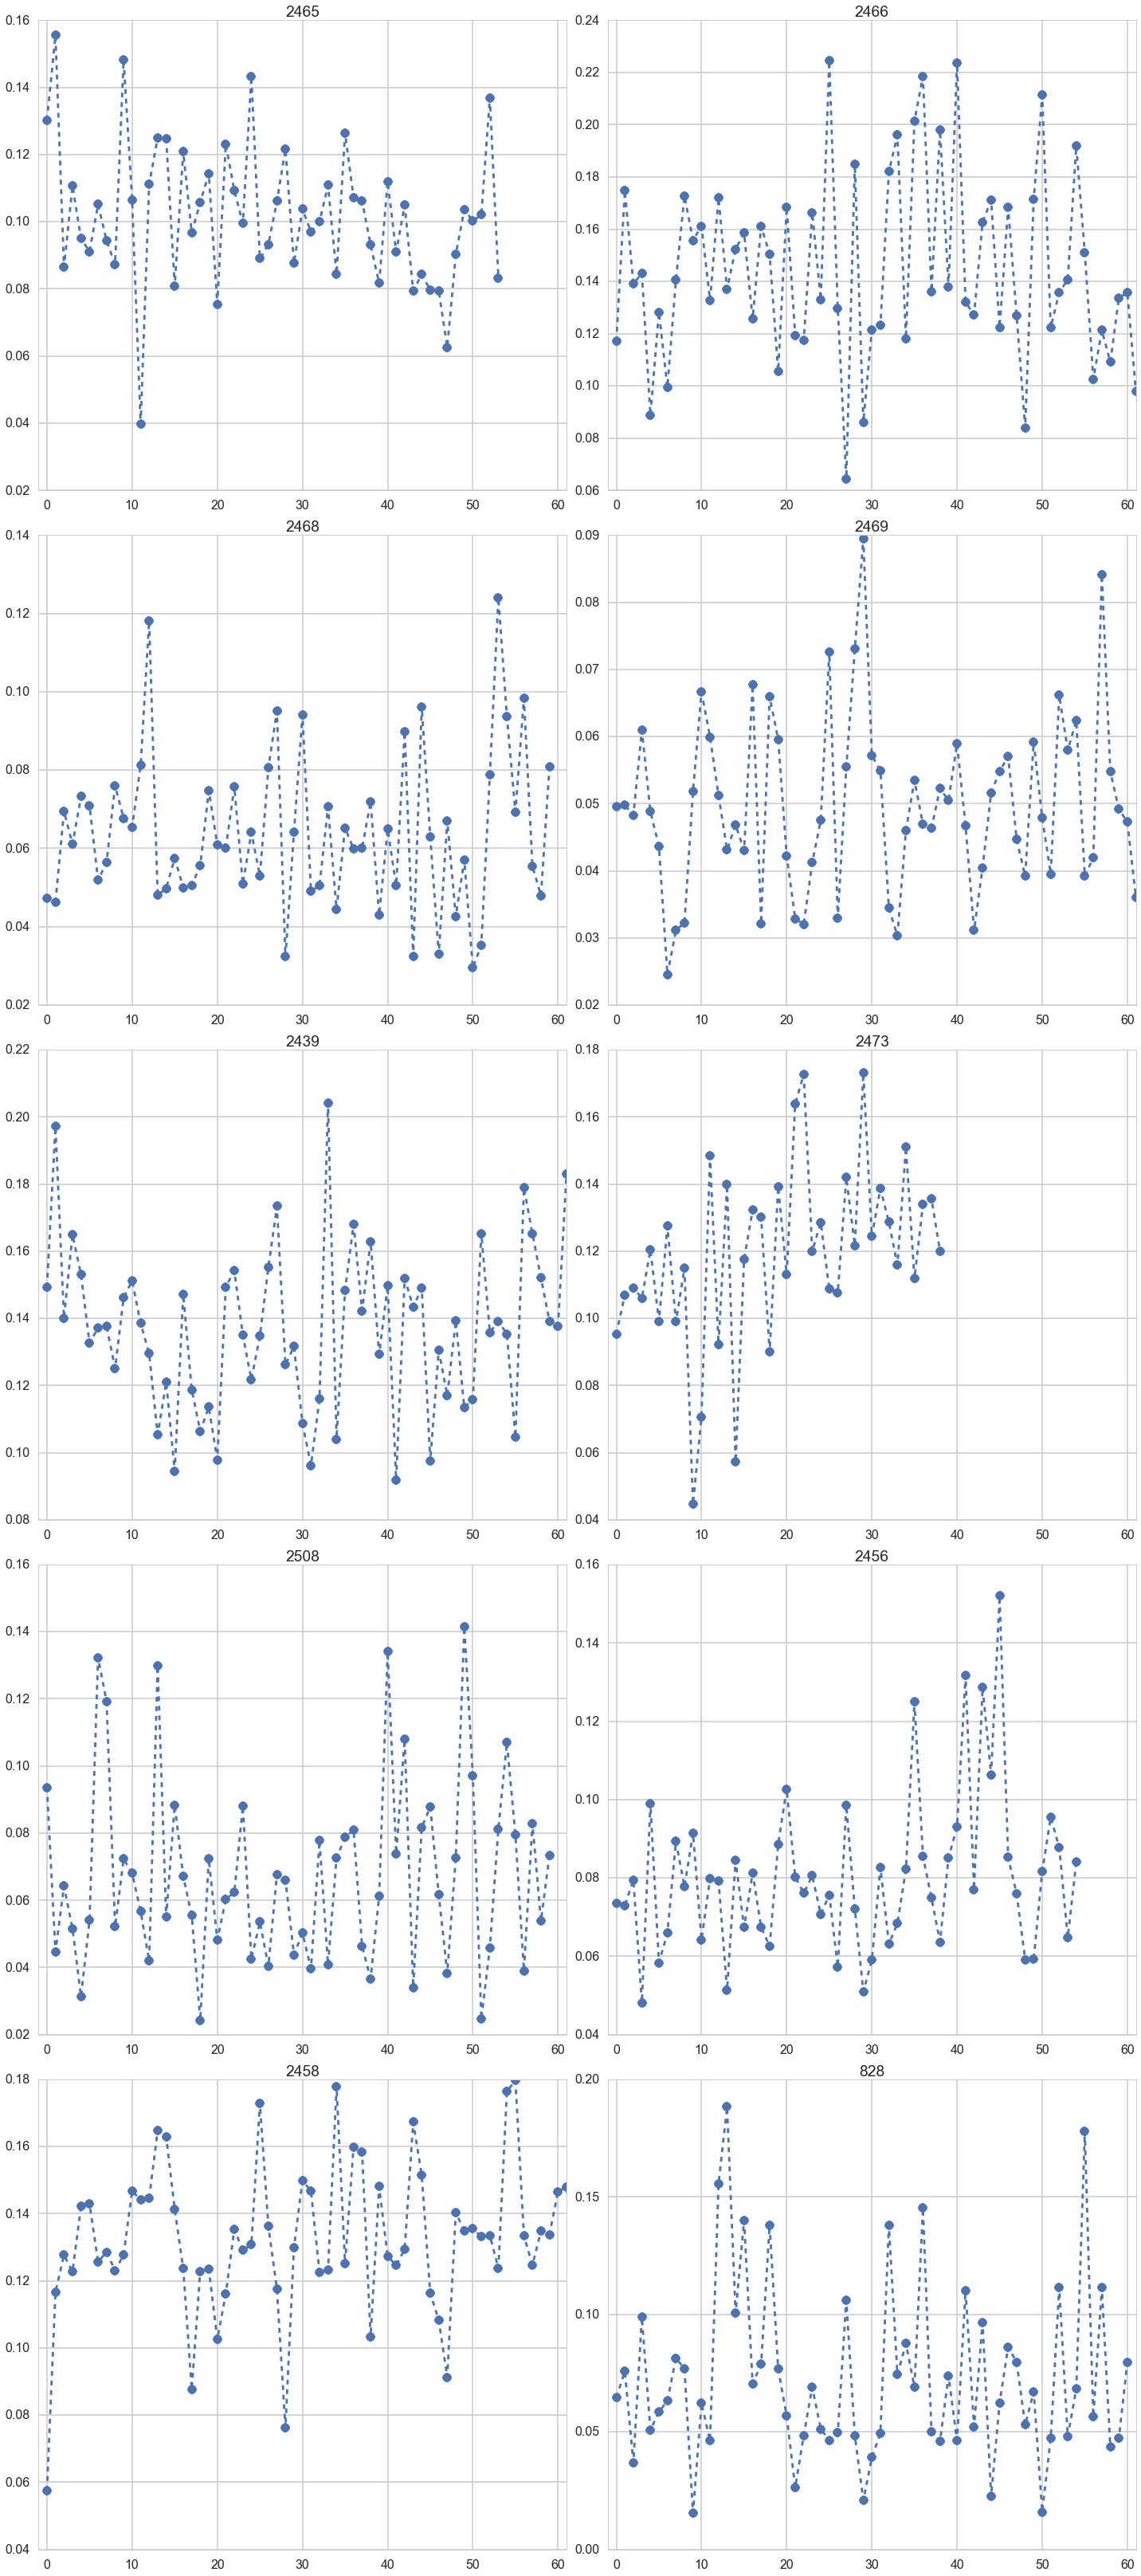

In [68]:
users = list(set(test.user_id.values))

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 45), tight_layout=True)
for ax, user in zip(axes.ravel(),users):
    person = test[test['user_id']==user]
    person = person.sort(['user_id', 'end_epoch'], ascending=[True, True]).reset_index(drop=True)
    person = person.drop(['start', 'end', 'score', 'time_in_bed', 'latency', 'disturbances', 
                      'wake_duration', 'light_sleep_duration', 'slow_wave_sleep_duration',
                     'cycles_count', 'rem_sleep_duration', 'debt_post', 'is_nap', 'recovery_score'], 1)
    groups = person.groupby(['user_id']).cumcount()
    daydf = pd.DataFrame(dict(days=groups))
    new_df = person.join(daydf, how='left')
    ax.plot(new_df.days, new_df.hrv_rmssd, marker='o', linestyle='--')
    ax.set_xlim(-1, 61)
    ax.set_title(user)

In [15]:
hrv_dict = {}

In [38]:
person = test[test['user_id']==828]
person = person.sort(['user_id', 'end_epoch'], ascending=[True, True]).reset_index(drop=True)
person = person.drop(['start', 'end', 'score', 'time_in_bed', 'latency', 'disturbances', 
                      'wake_duration', 'light_sleep_duration', 'slow_wave_sleep_duration',
                     'cycles_count', 'rem_sleep_duration', 'debt_post', 'is_nap', 'recovery_score'], 1)

In [43]:
groups = person.groupby(['user_id']).cumcount()
#plt.plot(person['date_md'], person['resting_heart_rate'])

In [44]:
daydf = pd.DataFrame(dict(days = groups))

In [46]:
new_df = person.join(daydf, how="left")

(30, 70)

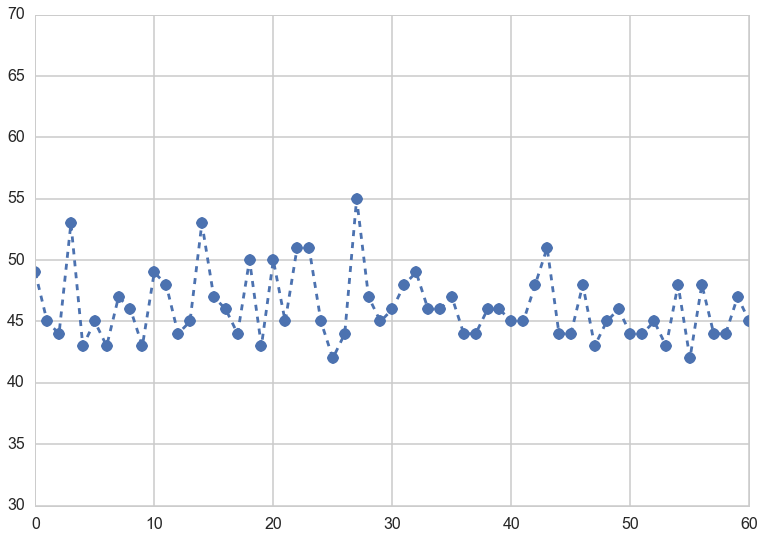

In [56]:
plt.plot(new_df.days, new_df.resting_heart_rate, marker='o', linestyle='--')
plt.ylim(30, 70)